# Various random walks
As stated in the previous notebook, there are many different possible "terrains" on which to conduct a random walk, consisting of different nodes and patterns of nodes and their connections.  In this notebook, we will re-visit the 1D and 2D grid random walks, and look into patterns of two, three, and four nodes.

In [1]:
from qiskit import *
from qiskit.visualization import *

## One-dimension random walk
Remember in the previous implementation, how we implement a separate incrementer and decrementer, consisting of many controlled gates, at least half of which we not powered at any given time?  Let's revert that problem to nodes, and consider only steps, so as to avoid the inefficiency inherent in using classical incrementation methods.

Reverting the line to nodes produces a string of $$2^n$$ nodes, where $$n$$ is the number of bits in the register indicating position, assuming we use the same scheme for numbering nodes (that is, declaring which possible measured states in the register correspond to which nodes) - this scheme declaring the starting node to be 0000, connected to 1111 and 0001, etc., as traditional integers with overflow.

The most efficient walk, ideally, would manipulate each bit independently - because in that case, the operations on each bit under the course of many steps might be compressible into a single, immediate operation.  While this is not always possible _to be honest, I don't know when it ever is possible yet_, it is still helpful to consider every bit individually.

In this case, begin with the least significant bit.  In every step on this graph, the least significant bit toggles.  This happens regardless of its value, those of the other bits, which node it steps to, or even the presence of other bits, and can be implemented conveniently with an x gate.  A register of one bit, or a random walk with on an axis of length 2, would have no choice anyhow, but to flip between 0 and 1 each step.
Next, consider the second-least significant bit, and a graph with nodes 00, 01, 10, and 11, connected in *that* order (we will consider other possibilities later).  Each step, that bit has half a chance of changing - it might, it might not.  For any one initial state of the register, this bit's changing or not changing indicates the choice of the next node between the two possible ones, even if neither changing nor not changing consistently corresponds to "incrementation" or "decrementation".  This can be implemented using a cx gate with a Hadamard coin as the control bit and the second-least significant bit as the target.
Next, consider the third-least significant bit, and the nodes connected in a cycle 000, 001, 010, 011, 100, 101, 110, and 111.  Thanks to the typical integer scheme, the two less significant bits will continue to traverse their porition of this state machine; we need only know when and how to change the third-least significant bit.  It changes in four cases: 000->111, 111->000, 011->100, and 100->011.  In general, it only changes, and always changes when *all* the bits less significant than it change - and when this happens, those bits all have the same value, and are thus all one either before or after their change.  This is the basis of the pattern used in the "crement" function below, which keeps an ancillary register with two fewer bits than the state register, which is repeatedly set to indicate whether the last so many digits are all one via a chain of Toffoli gates.

In [8]:
def crement(circuit, state, anc, coin):
    circuit.initialize('0',coin) # Yes, Hadamard coins must be initialized for each flip.
    circuit.h(coin)

    # Find initial ancillary states - how far do we have ones all the way back?
    circuit.initialize('0'*len(anc), anc)
    circuit.toffoli(state[0], state[1], anc[0])
    for s in range(1, len(anc)):
        circuit.toffoli(anc[s-1], state[s+1], anc[s])

    # Change the last two bits
    circuit.x(state[0])
    circuit.cx(coin, state[1])

    # Change for the ...111 -> ...000 case
    for s in range(2, len(state)):
       circuit.toffoli(coin, anc[s-2], state[s])
    
    # Re-calculate ancillary to check for ...000 -> ...111 case
    circuit.initialize('0'*len(anc), anc)
    circuit.toffoli(state[0], state[1], anc[0])
    circuit.toffoli(coin, anc[0], state[2])
    for s in range(1, len(anc)):
        circuit.toffoli(anc[s-1], state[s+1], anc[s]) # And change for that case as we go
        circuit.toffoli(coin, anc[s], state[s+2])    

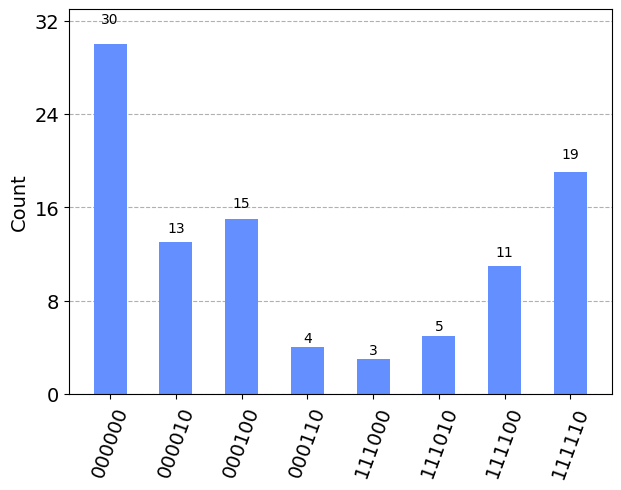

In [10]:
REGISTER_LENGTH = 6
STEPS = 10

q_pos = QuantumRegister(REGISTER_LENGTH)
anc = QuantumRegister(REGISTER_LENGTH - 2)
c_pos = ClassicalRegister(REGISTER_LENGTH)
coin = QuantumRegister(1)
qc = QuantumCircuit(q_pos, anc, c_pos, coin)

for i in range(STEPS):
    crement(qc, q_pos, anc, coin)

qc.measure(q_pos, c_pos)

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## Biaxial random walk 
Once again, this can be extended to the case of two axes - in this case, we are looking at a graph where each node is connected to four other nodes, and two coins are required to indicate a choice.  One of these coins could indicate a choice of axis down which to move, (in which case, it would flip the least significant bit of an axis, by controlling the flip of one, flipping itself, and controlling the flip of the other), and the other coin would match the role of the coin in the one-axis case.

In [ ]:
# Implement the bi-axial case

## Eight nodes, two axis

Also to add (solved on paper):
- two node case
- three node cases (V and triangle)
- four node cases